In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Masking, multiply, Reshape, Permute
from tensorflow.keras import optimizers
from matplotlib.colors import LinearSegmentedColormap

## Connect to database

In [2]:
schema_name = 'mimiciii'

con = psycopg2.connect(
    host = 'localhost',
    database = 'mimic',
    user = 'postgres',
)

cur = con.cursor()

cur.execute('SET search_path to ' + schema_name)

#con.close()

## Train Test Split
Split all encounter ids within cohort into a training set and a testing set.

In [3]:
hadm_id_df = pd.read_sql_query("select hadm_id from rnn_cohort", con)
hadm_id_np = hadm_id_df.values.flatten()
hadm_id_train, hadm_id_test = train_test_split(hadm_id_np, test_size=int(len(hadm_id_np) * 0.3), random_state=0)

In the training data, exclude ICU stays that have no vancomycin receipt across all 14 days.

In [4]:
design_matrix_train = pd.read_sql_query(
  """select * from rnn_design_matrix_padded
     where hadm_id in
     (
       select hadm_id from rnn_van_label
       where hadm_id in {}
       group by hadm_id
       having sum(van_flag)>0
     )""".format(tuple(hadm_id_train)), con)

In [5]:
design_matrix_test = pd.read_sql_query("""select * from rnn_design_matrix_padded
                                          where hadm_id in {}""".format(tuple(hadm_id_test)), con)

In [6]:
y_train = design_matrix_train['van_flag'].values.reshape((int(len(design_matrix_train)/14), 14, 1))
y_test = design_matrix_test['van_flag'].values.reshape((int(len(design_matrix_test)/14), 14, 1))

In [7]:
X_train = design_matrix_train.iloc[:, np.r_[1,3:32]].values.reshape((int(len(design_matrix_train)/14), 14, -1))
X_test = design_matrix_test.iloc[:, np.r_[1,3:32]].values.reshape((int(len(design_matrix_test)/14), 14, -1))

## Modeling

In [8]:
def Attention(inputs, TIME_STEPS):
    """
    inputs.shape = (batch_size, time_steps, input_dim)
    """ 
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

n_features = X_train.shape[2]
input_layer = Input(shape=(14, n_features))
x = Attention(input_layer, 14)
x = Masking(mask_value=0, input_shape=(14, n_features))(x) 
x = LSTM(100, activation='tanh', return_sequences=True, input_shape=(14, n_features))(x)
preds = TimeDistributed(Dense(1, activation="sigmoid"))(x)
model = Model(inputs=input_layer, outputs=preds)
#RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=False)
adam = optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, validation_data = (X_test, y_test), batch_size=16)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4359 samples, validate on 8138 samples
Epoch 1/100
4359/4359 [==============================] - 8s 2ms/sample - loss: 0.4139 - acc: 0.7662 - val_loss: 0.4149 - val_acc: 0.8275
Epoch 2/100
4359/4359 [==============================] - 4s 884us/sample - loss: 0.3655 - acc: 0.7877 - val_loss: 0.6949 - val_acc: 0.5794
Epoch 3/100
4359/4359 [==============================] - 4s 875us/sample - loss: 0.3530 - acc: 0.7970 - val_loss: 0.7702 - val_acc: 0.4868
Epoch 4/100
4359/4359 [==============================] - 4s 872us/sample - loss: 0.3397 - acc: 0.8085 - val_loss: 0.7023 - val_acc: 0.4929
Epoch 5/100
4359/4359 [==============================] - 4s 873us/sample - loss: 0.3356 - acc: 0.8097 - val_loss: 0.6539 - val_acc: 0.5319
Epoch 6/100
4359/4359 [==============================] - 4s 877us/sample - loss: 0.3283 - acc: 0.8095 - val_loss: 0.6744 - val_acc: 0.5087
Epoch 7/100
4359/4359 [===

Epoch 57/100
4359/4359 [==============================] - 4s 868us/sample - loss: 0.3018 - acc: 0.8282 - val_loss: 0.5122 - val_acc: 0.7312
Epoch 58/100
4359/4359 [==============================] - 4s 871us/sample - loss: 0.3015 - acc: 0.8285 - val_loss: 0.4654 - val_acc: 0.7695
Epoch 59/100
4359/4359 [==============================] - 4s 869us/sample - loss: 0.2992 - acc: 0.8315 - val_loss: 0.4813 - val_acc: 0.7644
Epoch 60/100
4359/4359 [==============================] - 4s 871us/sample - loss: 0.3014 - acc: 0.8288 - val_loss: 0.4967 - val_acc: 0.7529
Epoch 61/100
4359/4359 [==============================] - 4s 869us/sample - loss: 0.3017 - acc: 0.8296 - val_loss: 0.5008 - val_acc: 0.7395
Epoch 62/100
4359/4359 [==============================] - 4s 867us/sample - loss: 0.3004 - acc: 0.8302 - val_loss: 0.4472 - val_acc: 0.7910
Epoch 63/100
4359/4359 [==============================] - 4s 867us/sample - loss: 0.2977 - acc: 0.8333 - val_loss: 0.4342 - val_acc: 0.8013
Epoch 64/100
4359/43

## Visualize performance

In [9]:
def predict_next_day(day):
    '''
    design_matrix_next_day = pd.read_sql_query("""select * from rnn_design_matrix_padded
      where hadm_id in {}
        and hadm_id in
        (select hadm_id
         from rnn_cohort
         where length_of_stay >= {}
        )
      """.format(tuple(hadm_id_test), day), con)
    y_test = design_matrix_next_day['van_flag'].values.reshape((int(len(design_matrix_next_day)/14), 14, 1))
    X_test = design_matrix_next_day.iloc[:, np.r_[1,3:32]].values.reshape((int(len(design_matrix_next_day)/14), 14, -1))
    X_test[:, (day-1):, :] = 0
    y_hat = model.predict(X_test)[:, int(day-1)].flatten()
    '''
    
    X_test_next_day = X_test.copy()
    X_test_next_day[:, (day-1):, :] = 0
    y_hat = model.predict(X_test_next_day)[:, int(day-1)].flatten()
    auc = metrics.roc_auc_score(y_test[:, int(day-1)].flatten(), y_hat)
    fpr, tpr, thresholds = metrics.roc_curve(y_test[:, int(day-1)].flatten(), y_hat)
    return auc, fpr, tpr, thresholds

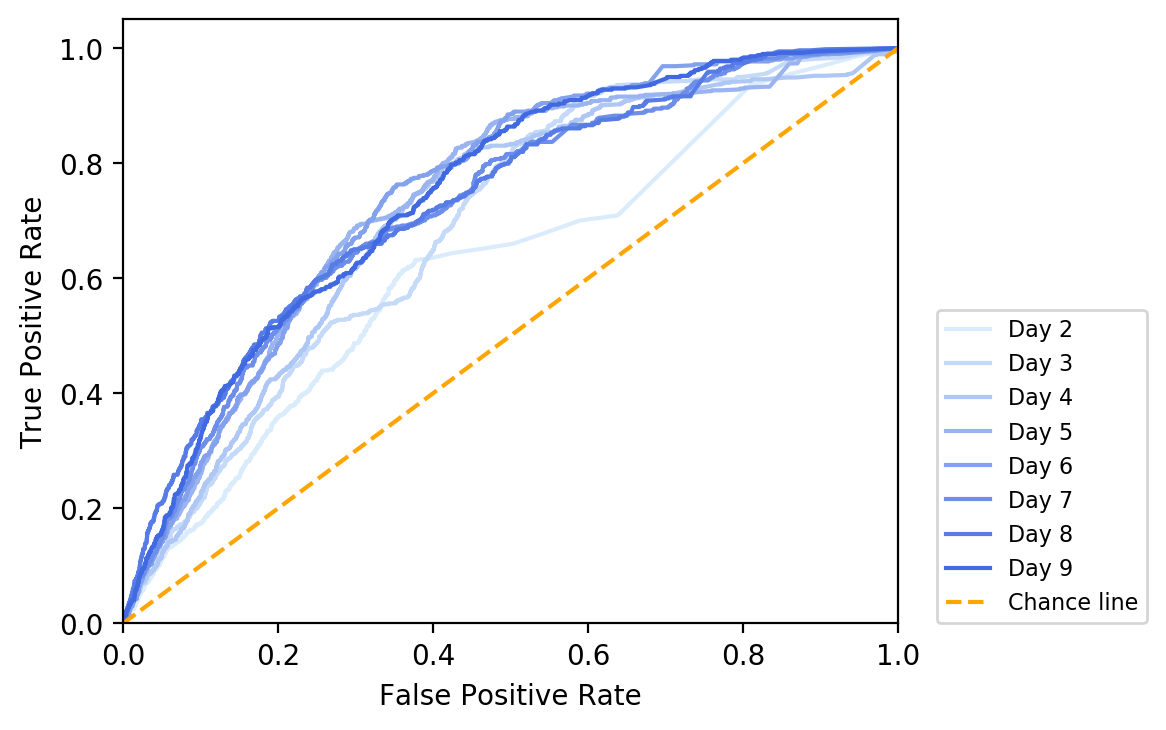

In [11]:
colors = ['azure', 'royalblue']
cm = LinearSegmentedColormap.from_list('my', colors, N=9)
plt.figure(dpi=200, figsize=(5,4))
for i in range(2, 10):
    auc, fpr, tpr, thresholds = predict_next_day(i)
    plt.plot(fpr, tpr, color = cm(1/8*(i-1)), label='Day {}'.format(i))
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance line', color='orange')
#plt.text(0.7,0.25,"AUC = %.3f" % auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(1.05, 0), prop={'size': 8})